# House prices

#### Objective:
- Predict sale prices of houses from descriptive data of them

#### Model:
- Extreme gradient boosting

In [1]:
! pip install hyperopt

In [2]:
# Packages needed
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from hyperopt import hp, tpe, fmin
import matplotlib.pyplot as plt

## Lecture of the dataset and preprocessing

In [3]:
#path to dataset
#CHANGE AS NEEDED
df=pd.read_csv (r'C:\Users\phili\Documents\Machine Learning\Kaggle\House Prices\train.csv')
# Separate X and y
y=df["SalePrice"].values
df=df.loc[:, df.columns != "SalePrice"]

- Size and first lines of the dataframe:

In [4]:
print("Size of the dataset :",df.shape)
df.head()

Size of the dataset : (1460, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


- The two first columns look similar, check and delete one. Verify if some features are in double

In [5]:
if np.array_equal(df.index.tolist(),np.array(df["Id"].tolist())-1):
    print("True")
    del df["Id"]
    
# Check for features in double
feature_names = df.columns.tolist()
for i in range(len(feature_names)):
    if feature_names.count(feature_names[i])!=1:
        print(feature_names[i])

True


- Some statistics of the dataframe

In [6]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


- Types of features and change int to floats

In [7]:
# Looks at types and change int to floats
numbInt=0
numbCont=0
numbCat=0
for x in df.columns:
    if(df[x].dtype==np.float64):
        numbCont+=1
    if(df[x].dtype==np.int64):
        numbInt+=1
        df[x]=df[x].astype(float) # if we want to transform all the int features to float features
    elif(df[x].dtype==np.object):
        numbCat+=1
print("Number of continuous features : " , numbCont,", of int features : " , numbInt,", of categorical features : " , numbCat , "\n")

Number of continuous features :  3 , of int features :  33 , of categorical features :  43 



- Check is the categorical features look badly filled

In [8]:
for x in df.columns:
    if(df[x].dtype==np.object):
        print("Values of feature", x, ":",df[x].unique())

Values of feature MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH']
Values of feature Street : ['Pave' 'Grvl']
Values of feature Alley : [nan 'Grvl' 'Pave']
Values of feature LotShape : ['Reg' 'IR1' 'IR2' 'IR3']
Values of feature LandContour : ['Lvl' 'Bnk' 'Low' 'HLS']
Values of feature Utilities : ['AllPub' 'NoSeWa']
Values of feature LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Values of feature LandSlope : ['Gtl' 'Mod' 'Sev']
Values of feature Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Values of feature Condition1 : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Values of feature Condition2 : ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
Values of feature BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Values of feature Hous

- Log transform of the target feature to obtain a normally distributed variable

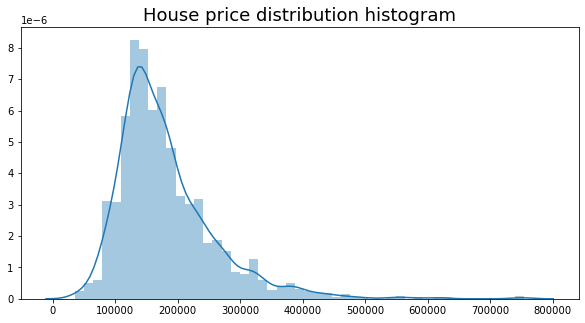

In [9]:
plt.figure(figsize=(10, 5))
sns.distplot(y).set(ylabel=None, xlabel=None)
plt.title('House price distribution histogram', fontsize=18)
plt.show()

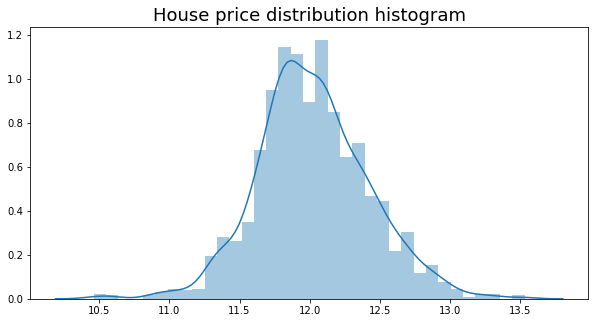

In [10]:
y=np.log1p(y)
plt.figure(figsize=(10, 5))
sns.distplot(y).set(ylabel=None, xlabel=None)
plt.title('House price distribution histogram', fontsize=18)
plt.show()

- Creation of two new features: the total surface and the total number of baths

In [11]:
df['TotalSF'] = df['GrLivArea']+df['TotalBsmtSF']
df['TotalBaths'] = df['FullBath']+.5*df['HalfBath']

- New binary feature remodeling or not

In [12]:
newcol=[]
for i in range(len(df["YearRemodAdd"])):
    if df["YearRemodAdd"][i]!=df["YearRemodAdd"][i] or df["YearBuilt"][i]!=df["YearBuilt"][i]:
        newcol.append(np.nan)
    else:
        if df["YearRemodAdd"][i]==df["YearBuilt"][i]:
            newcol.append(0)
        else:
            newcol.append(1)
df["Remodornot"]=newcol

- Fill missing values in FireplaceQu using Fireplaces

In [13]:
for i in range(len(df["FireplaceQu"])):
    if df["Fireplaces"][i]==0:
        df["FireplaceQu"][i]="NA"

- Fill missing values for features related to garage

In [14]:
"""
for i in range(len(df["GarageCond"])):
    if df["GarageCond"][i]!=df["GarageCond"][i]:
        df["GarageCond"][i]="NA"
        df["GarageQual"][i]="NA"
        df["GarageFinish"][i]="NA"
        df["GarageType"][i]="NA"
"""

'\nfor i in range(len(df["GarageCond"])):\n    if df["GarageCond"][i]!=df["GarageCond"][i]:\n        df["GarageCond"][i]="NA"\n        df["GarageQual"][i]="NA"\n        df["GarageFinish"][i]="NA"\n        df["GarageType"][i]="NA"\n'

- Label encoding for some features

In [15]:
def labelenc(col,label):
    dicLabel={}
    for i in range(len(label)):
        dicLabel[label[i]]=i
    newcol=[]
    for i in range(len(col)):
        if col[i]!=col[i]:
            newcol.append(np.nan)
        else:
            newcol.append(dicLabel[col[i]])
    return newcol

In [16]:
df["LotShape"]=labelenc(df["LotShape"].values,["IR3","IR2","IR1","Reg"])
df["Utilities"]=labelenc(df["Utilities"].values,["ELO","NoSeWa","NoSewr","AllPub"])
#df["LotConfig"]=labelenc(df["LotConfig"].values,["FR3","FR2","CulDSac","Corner","Inside"])
df["LandSlope"]=labelenc(df["LandSlope"].values,["Sev","Mod","Gtl"])
df["ExterQual"]=labelenc(df["ExterQual"].values,["Po","Fa","TA","Gd","Ex"])
df["ExterCond"]=labelenc(df["ExterCond"].values,["Po","Fa","TA","Gd","Ex"])
df["BsmtQual"]=labelenc(df["BsmtQual"].values,["NA","Po","Fa","TA","Gd","Ex"])
df["BsmtCond"]=labelenc(df["BsmtCond"].values,["NA","Po","Fa","TA","Gd","Ex"])
df["BsmtExposure"]=labelenc(df["BsmtExposure"].values,["NA","No","Mn","Av","Gd"])
df["BsmtFinType1"]=labelenc(df["BsmtFinType1"].values,["NA","Unf","LwQ","Rec","BLQ","ALQ","GLQ"])
df["BsmtFinType2"]=labelenc(df["BsmtFinType2"].values,["NA","Unf","LwQ","Rec","BLQ","ALQ","GLQ"])
df["HeatingQC"]=labelenc(df["HeatingQC"].values,["Po","Fa","TA","Gd","Ex"])
#df["Electrical"]=labelenc(df["Electrical"].values,["Mix","FuseP","FuseF","FuseA","SBrkr"])
df["KitchenQual"]=labelenc(df["KitchenQual"].values,["Po","Fa","TA","Gd","Ex"])
df["Functional"]=labelenc(df["Functional"].values,["Sal","Sev","Maj2","Maj1","Mod","Min2","Min1","Typ"])
df["FireplaceQu"]=labelenc(df["FireplaceQu"].values,["NA","Po","Fa","TA","Gd","Ex"])
df["GarageFinish"]=labelenc(df["GarageFinish"].values,["NA","Unf","RFn","Fin"])
df["GarageQual"]=labelenc(df["GarageQual"].values,["NA","Po","Fa","TA","Gd","Ex"])
df["GarageCond"]=labelenc(df["GarageCond"].values,["NA","Po","Fa","TA","Gd","Ex"])
df["PavedDrive"]=labelenc(df["PavedDrive"].values,["N","P","Y"])
df["CentralAir"]=labelenc(df["CentralAir"].values,["N","Y"])

for x in df.columns:
    if(df[x].dtype==np.int64):
        df[x]=df[x].astype(float) # if we want to transform all the int features to float features

- Change the types of some numerical features that should be categorical (nominal)

In [17]:
df["MSSubClass"] = df["MSSubClass"].astype(str)
df["YrSold"] = df["YrSold"].astype(str)
df["MoSold"] = df["MoSold"].astype(str)

## Machine Learning
##### Model: Extreme gradient boosting

- Split Train and Test

In [18]:
# Split train and test
X=df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape,X_test.shape)

(1022, 82) (438, 82)


- Mean normalisation

In [19]:
# Mean normalisation for continuous and int columns
dictMeanStd={}
for x in X_train.columns:
    if (X_train[x].dtype!=np.object):
        dictMeanStd[x]=[X_train[x].mean(),X_train[x].std()]
        X_train[x]=(X_train[x]-dictMeanStd[x][0])/dictMeanStd[x][1]

- Handle missing values

In [20]:
# Missing Values
print("Number of lines where at least one value is missing", sum([True for idx,row in X_train.iterrows() if any(row.isnull())]))
print("Which is",sum([True for idx,row in X_train.iterrows() if any(row.isnull())])/len(X_train)*100," % of the dataset.")
print(X_train.isnull().sum().sort_values())
# Delete Features with too much missing values
del X_train["Fence"]
del X_train["Alley"]
del X_train["MiscFeature"]
del X_train["PoolQC"]

Number of lines where at least one value is missing 1022
Which is 100.0  % of the dataset.
MSSubClass         0
KitchenQual        0
KitchenAbvGr       0
BedroomAbvGr       0
HalfBath           0
                ... 
LotFrontage      188
Fence            831
Alley            960
MiscFeature      983
PoolQC          1018
Length: 82, dtype: int64


In [21]:
# Missing values for some categorical features with mode
"""
catFeatMode=['Electrical','MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional']
dictMode={}
for x in catFeatMode:
    if(X_train[x].dtype==np.object):
        dictMode[x]=X_train[x].mode()[0]
        X_train[x] = np.where(X_train[x].isnull(),dictMode[x],X_train[x])
"""

"\ncatFeatMode=['Electrical','MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional']\ndictMode={}\nfor x in catFeatMode:\n    if(X_train[x].dtype==np.object):\n        dictMode[x]=X_train[x].mode()[0]\n        X_train[x] = np.where(X_train[x].isnull(),dictMode[x],X_train[x])\n"

In [22]:
# Create new category Unknown for missing values in the other cat features
for x in X_train.columns:
    if(X_train[x].dtype==np.object):
        X_train[x] = np.where(X_train[x].isnull(),"Unknown",X_train[x])

# Put 0 where values are missing for cont and int features
X_train=X_train.replace(np.nan,0)

- Detection of outliers and suppression of them

In [23]:
# Be careful to suppress also values in y_train
threshold=7
X_train['SalePrice']=y_train
X_train['outliers']=0
for x in X_train.columns:
    if(X_train[x].dtype!=np.object and x!='outliers' and x!='SalePrice'):
        X_train.loc[(X_train[x]-X_train[x].mean()).abs() > threshold*X_train[x].std(),'outliers'] = 1

print("The number of outliers is:",sum(X_train['outliers']))
X_train=X_train[X_train.outliers==0].reset_index(drop=True)
y_train=X_train['SalePrice'].values
del X_train["SalePrice"]
del X_train["outliers"]

The number of outliers is: 44


- OneHotEncoding on categorical features

In [24]:
# Separate cat and float features to do a onehotencoding on cat features
X_traintemp=X_train.select_dtypes('object')
enc=OneHotEncoder(handle_unknown = 'ignore')
enc.fit(X_traintemp)
X_traintemp=enc.transform(X_traintemp).toarray()
X_train=np.concatenate([X_traintemp,X_train.select_dtypes('float64').values],axis=1)
print(X_train.shape)

(978, 239)


#### Model

In [25]:
# Choice of the model
regressor=xgb.XGBRegressor()
#regressor = xgb.XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.01,max_depth = 3,n_estimators = 1000)

#### PCA

- Cross-validation (without k-fold)

In [26]:
"""
cv_hyperp_pca=[2*i for i in range(2,50)]

bestparams=[-1]
minRMSE=1000000000

for i in cv_hyperp_pca:
    X_cv=X_train
    y_cv=y_train
    X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X_cv, y_cv, test_size=0.3, random_state=1)
    pca = PCA(n_components=i)
    pca.fit(X_cv_train)
    X_cv_train=pca.transform(X_cv_train)
    X_cv_test=pca.transform(X_cv_test)

    regressor.fit(X_cv_train, y_cv_train)
    y_cv_train_pred=regressor.predict(X_cv_train)
    y_cv_test_pred=regressor.predict(X_cv_test)
    localRMSE=np.sqrt(metrics.mean_squared_log_error(np.maximum(y_cv_test_pred,0),np.maximum(y_cv_test,0)))
    print("Accuracy for param PCA dim", i,"RMSLE %.3f" % localRMSE,"MSE %.0f" % np.sqrt(metrics.mean_squared_error(y_cv_test_pred,y_cv_test)))
    if localRMSE<minRMSE:
        minRMSE=localRMSE
        bestparams=[i]
        
print("\n")
print("Best params: PCA dim", bestparams[0])
dim_pca=bestparams[0]
"""

'\ncv_hyperp_pca=[2*i for i in range(2,50)]\n\nbestparams=[-1]\nminRMSE=1000000000\n\nfor i in cv_hyperp_pca:\n    X_cv=X_train\n    y_cv=y_train\n    X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X_cv, y_cv, test_size=0.3, random_state=1)\n    pca = PCA(n_components=i)\n    pca.fit(X_cv_train)\n    X_cv_train=pca.transform(X_cv_train)\n    X_cv_test=pca.transform(X_cv_test)\n\n    regressor.fit(X_cv_train, y_cv_train)\n    y_cv_train_pred=regressor.predict(X_cv_train)\n    y_cv_test_pred=regressor.predict(X_cv_test)\n    localRMSE=np.sqrt(metrics.mean_squared_log_error(np.maximum(y_cv_test_pred,0),np.maximum(y_cv_test,0)))\n    print("Accuracy for param PCA dim", i,"RMSLE %.3f" % localRMSE,"MSE %.0f" % np.sqrt(metrics.mean_squared_error(y_cv_test_pred,y_cv_test)))\n    if localRMSE<minRMSE:\n        minRMSE=localRMSE\n        bestparams=[i]\n        \nprint("\n")\nprint("Best params: PCA dim", bestparams[0])\ndim_pca=bestparams[0]\n'

- Preprocess test

In [27]:
# Mean normalization
for x in X_test.columns:
    if (X_test[x].dtype!=np.object):
        X_test[x]=(X_test[x]-dictMeanStd[x][0])/dictMeanStd[x][1]

# Missing Values
del X_test["Fence"]
del X_test["Alley"]
del X_test["MiscFeature"]
del X_test["PoolQC"]

"""
for x in catFeatMode:
    if(X_test[x].dtype==np.object):
        X_test[x] = np.where(X_test[x].isnull(),dictMode[x],X_test[x])
"""
for x in X_test.columns:
    if(X_test[x].dtype==np.object):
        X_test[x] = np.where(X_test[x].isnull(),"Unknown",X_test[x])

X_test=X_test.replace(np.nan,0)

# One Hot Encoding
X_testtemp=X_test.select_dtypes('object')
X_testtemp=enc.transform(X_testtemp).toarray()
X_test=np.concatenate([X_testtemp,X_test.select_dtypes('float64').values],axis=1)
print(X_train.shape,X_test.shape)

(978, 239) (438, 239)


- PCA

In [28]:
# PCA
"""
pca = PCA(n_components=dim_pca)
pca.fit(X_train)
X_train=pca.transform(X_train)
X_test=pca.transform(X_test)
"""

'\npca = PCA(n_components=dim_pca)\npca.fit(X_train)\nX_train=pca.transform(X_train)\nX_test=pca.transform(X_test)\n'

- CV for hyperparam of the model

In [29]:
# CV
"""
regressor = RandomForestRegressor()
param_grid = {'n_estimators': [5*i for i in range(1,10)], 'max_depth': [2*i for i in range(1,8)], 'criterion': ['mse', 'mae']}
grid_clf = GridSearchCV(regressor, param_grid, cv=10)
grid_clf.fit(X_train, y_train)
print('Best parameters :', grid_clf.best_params_)"""

"\nregressor = RandomForestRegressor()\nparam_grid = {'n_estimators': [5*i for i in range(1,10)], 'max_depth': [2*i for i in range(1,8)], 'criterion': ['mse', 'mae']}\ngrid_clf = GridSearchCV(regressor, param_grid, cv=10)\ngrid_clf.fit(X_train, y_train)\nprint('Best parameters :', grid_clf.best_params_)"

- Fitting the model

In [30]:
space = {'n_estimators':hp.quniform('n_estimators', 1000, 4000, 100),
         'gamma':hp.uniform('gamma', 0.01, 0.05),
         'learning_rate':hp.uniform('learning_rate', 0.00001, 0.025),
         'max_depth':hp.quniform('max_depth', 3,7,1),
         'subsample':hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.98),
         'colsample_bylevel':hp.uniform('colsample_bylevel', 0.60, 0.98),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20)
        }

def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'gamma': params['gamma'],
             'learning_rate': params['learning_rate'],
             'max_depth': int(params['max_depth']),
             'subsample': params['subsample'],
             'colsample_bytree': params['colsample_bytree'],
             'colsample_bylevel': params['colsample_bylevel'],
             'reg_lambda': params['reg_lambda']}
    
    xb_a= xgb.XGBRegressor(**params)
    score = cross_val_score(xb_a, X_train, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1).mean()
    return -score

best = fmin(fn= objective, space= space, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)

regressor = xgb.XGBRegressor(random_state=0,
                        n_estimators=int(best['n_estimators']), 
                        colsample_bytree= best['colsample_bytree'],
                        gamma= best['gamma'],
                        learning_rate= best['learning_rate'],
                        max_depth= int(best['max_depth']),
                        subsample= best['subsample'],
                        colsample_bylevel= best['colsample_bylevel'],
                        reg_lambda= best['reg_lambda']
                       )

100%|██████████| 20/20 [11:26<00:00, 34.34s/trial, best loss: 0.013638348195049143]


In [31]:
#regressor = RandomForestRegressor(max_depth=grid_clf.best_params_['max_depth'],n_estimators=grid_clf.best_params_['n_estimators'],criterion=grid_clf.best_params_['criterion'])
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6020946617238414, colsample_bynode=1,
             colsample_bytree=0.7872059560039623, gamma=0.011461779602481683,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.01590800161825219, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3500, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=15.038708861729809, scale_pos_weight=1,
             subsample=0.7106509085449073, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [32]:
y_train_pred=regressor.predict(X_train)
y_train_pred=np.maximum(y_train_pred,0) # If some coordinates are negatives
print("RMSLE on the train:", np.sqrt(metrics.mean_squared_log_error(y_train_pred,y_train)))
y_pred=regressor.predict(X_test)
y_pred=np.maximum(y_pred,0) # If some coordinates are negatives
print("RMSLE on the test:", np.sqrt(metrics.mean_squared_log_error(y_pred,y_test)))

RMSLE on the train: 0.003310407745456165
RMSLE on the test: 0.010882362871720291


# Submission part

In [33]:
# Import submission
sub=pd.read_csv (r'C:\Users\phili\Documents\Machine Learning\Kaggle\House Prices\test.csv')
del sub["Id"]

In [34]:
sub['TotalSF'] = sub['GrLivArea']+sub['TotalBsmtSF']
sub['TotalBaths'] = sub['FullBath']+.5*sub['HalfBath']

sub["MSSubClass"] = sub["MSSubClass"].astype(str)
sub["YrSold"] = sub["YrSold"].astype(str)
sub["MoSold"] = sub["MoSold"].astype(str)

newcol=[]
for i in range(len(sub["YearRemodAdd"])):
    if sub["YearRemodAdd"][i]!=sub["YearRemodAdd"][i] or sub["YearBuilt"][i]!=sub["YearBuilt"][i]:
        newcol.append(np.nan)
    else:
        if sub["YearRemodAdd"][i]==sub["YearBuilt"][i]:
            newcol.append(0)
        else:
            newcol.append(1)
sub["Remodornot"]=newcol

for i in range(len(sub["FireplaceQu"])):
    if sub["Fireplaces"][i]==0:
        sub["FireplaceQu"][i]="NA"

"""
for i in range(len(sub["GarageCond"])):
    if sub["GarageCond"][i]!=sub["GarageCond"][i]:
        sub["GarageCond"][i]="NA"
        sub["GarageQual"][i]="NA"
        sub["GarageFinish"][i]="NA"
        sub["GarageType"][i]="NA"
"""

sub["ExterQual"]=labelenc(sub["ExterQual"].values,["Po","Fa","TA","Gd","Ex"])
sub["LotShape"]=labelenc(sub["LotShape"].values,["IR3","IR2","IR1","Reg"])
sub["Utilities"]=labelenc(sub["Utilities"].values,["ELO","NoSeWa","NoSewr","AllPub"])
#sub["LotConfig"]=labelenc(sub["LotConfig"].values,["FR3","FR2","CulDSac","Corner","Inside"])
sub["LandSlope"]=labelenc(sub["LandSlope"].values,["Sev","Mod",'Gtl'])
sub["ExterCond"]=labelenc(sub["ExterCond"].values,["Po","Fa","TA","Gd","Ex"])
sub["BsmtQual"]=labelenc(sub["BsmtQual"].values,["NA","Po","Fa","TA","Gd","Ex"])
sub["BsmtCond"]=labelenc(sub["BsmtCond"].values,["NA","Po","Fa","TA","Gd","Ex"])
sub["BsmtExposure"]=labelenc(sub["BsmtExposure"].values,["NA","No","Mn","Av","Gd"])
sub["BsmtFinType1"]=labelenc(sub["BsmtFinType1"].values,["NA","Unf","LwQ","Rec","BLQ","ALQ","GLQ"])
sub["BsmtFinType2"]=labelenc(sub["BsmtFinType2"].values,["NA","Unf","LwQ","Rec","BLQ","ALQ","GLQ"])
sub["HeatingQC"]=labelenc(sub["HeatingQC"].values,["Po","Fa","TA","Gd","Ex"])
#sub["Electrical"]=labelenc(sub["Electrical"].values,["Mix","FuseP","FuseF","FuseA","SBrkr"])
sub["KitchenQual"]=labelenc(sub["KitchenQual"].values,["Po","Fa","TA","Gd","Ex"])
sub["Functional"]=labelenc(sub["Functional"].values,["Sal","Sev","Maj2","Maj1","Mod","Min2","Min1","Typ"])
sub["FireplaceQu"]=labelenc(sub["FireplaceQu"].values,["NA","Po","Fa","TA","Gd","Ex"])
sub["GarageFinish"]=labelenc(sub["GarageFinish"].values,["NA","Unf","RFn","Fin"])
sub["GarageQual"]=labelenc(sub["GarageQual"].values,["NA","Po","Fa","TA","Gd","Ex"])
sub["GarageCond"]=labelenc(sub["GarageCond"].values,["NA","Po","Fa","TA","Gd","Ex"])
sub["PavedDrive"]=labelenc(sub["PavedDrive"].values,["N","P","Y"])
sub["CentralAir"]=labelenc(sub["CentralAir"].values,["N","Y"])

for x in df.columns:
    if(df[x].dtype==np.int64):
        df[x]=df[x].astype(float) # if we want to transform all the int features to float features

# Mean normalization
for x in sub.columns:
    if (sub[x].dtype!=np.object):
        sub[x]=(sub[x]-dictMeanStd[x][0])/dictMeanStd[x][1]
# Missing Values
del sub["Fence"]
del sub["Alley"]
del sub["MiscFeature"]
del sub["PoolQC"]

"""
for x in catFeatMode:
    if(sub[x].dtype==np.object):
        sub[x] = np.where(sub[x].isnull(),dictMode[x],sub[x])
"""
for x in sub.columns:
    if(sub[x].dtype==np.object):
        sub[x] = np.where(sub[x].isnull(),"Unknown",sub[x])
sub=sub.replace(np.nan,0)

# One Hot Encoding
subtemp=sub.select_dtypes('object')
subtemp=enc.transform(subtemp).toarray()
sub=np.concatenate([subtemp,sub.select_dtypes('float64').values],axis=1)
# PCA
#sub=pca.transform(sub)

In [35]:
# Predict
y_submission_pred=regressor.predict(sub)
y_submission_pred=np.maximum(y_submission_pred,0)
# Export
#CHANGE AS NEEDED
export=pd.read_csv (r'C:\Users\phili\Documents\Machine Learning\Kaggle\House Prices\test.csv')
export=pd.DataFrame(export["Id"])
y_submission_pred=(np.expm1(y_submission_pred))
export["SalePrice"]=y_submission_pred
export.to_csv (r'C:\Users\phili\Documents\Machine Learning\Kaggle\House Prices\export_sub.csv', index = False, header=True)